In [ ]:
import sys
sys.path.append("..")
import grading
import download_utils

In [ ]:
download_utils.link_all_keras_resources()

In [ ]:
import tensorflow as tf
import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import keras, keras.layers as L
import keras.backend as K
import tqdm
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os

Using TensorFlow backend.


In [ ]:
IMG_SIZE = 299

In [ ]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(0)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.engine.training.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

In [ ]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [ ]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['val2014_sample.zip', 'train2014_sample.zip']

In [ ]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))

train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip",
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip",
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


In [ ]:
train_img_fns[0],train_captions[1]

('COCO_train2014_000000270070.jpg',
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another'])

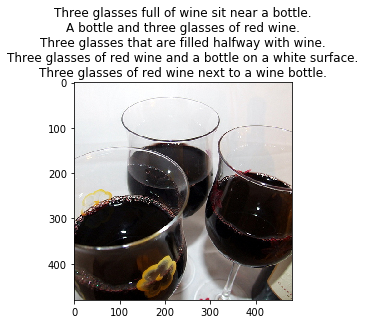

In [ ]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()

show_trainig_example(train_img_fns, train_captions, example_idx=140)

In [ ]:
# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [ ]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

In [ ]:
# words = [word for caption_set in [train_captions,val_captions] for sample in caption_set for caption in sample for word in split_sentence(caption) ]
# len(words), words[:4]

In [ ]:
from collections import defaultdict

In [ ]:
# split_sentence(train_captions[0][0])

In [ ]:
def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more,
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary),
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    vocab = {token: idx for idx,token in enumerate([PAD,UNK,START,END])}
    current_idx = len(vocab)
    frequency = defaultdict(int)
#     vocab = ### YOUR CODE HERE ###
    for caption_set in [train_captions] : #,val_captions
        for sample in caption_set:
            for caption in sample:
                for word in split_sentence(caption):
                    frequency[word] +=1
                    if frequency[word] >= 5 and word not in vocab:
                        vocab[word] = current_idx
    return {token: index for index, token in enumerate(sorted(vocab))}

def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    res = []
    for caption_set in captions:
        res.append([])
        for caption in caption_set:
            current_vocab_vec = []
            for word in split_sentence(caption):
                if word in vocab:
                    current_vocab_vec.append(vocab[word])
                else:
                    current_vocab_vec.append(vocab[UNK])
            res[-1].append([vocab[START]]+current_vocab_vec+[vocab[END]])
#     res = ### YOUR CODE HERE ###
    return res

In [ ]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [ ]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

In [ ]:
# # a = np.array([[1, 2, 3], [4, 5]])
# # np.delete(a,2,1)
# a = [[1, 2, 3], [4, 5],[6,7,8,9]]
# # b = np.array()
# # for r in a:
# #     print (r)
# #     b = np.append(b,np.array(r[:2]))
# l = 3#max(map(len, a))
# m = np.ones((len(a),l))*-1#vocab[PAD]
# m
# for idx, row in enumerate(a):
#     try:
#         m[idx, :len(row)] = np.array(row)[:l]
#     except ValueError:
#         pass  # broadcasting error: row is empty
# m

In [ ]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with vocab[PAD] where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, vocab[PAD]]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, vocab[PAD]]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    l = max(map(len, batch_captions))
    if max_len != None:
        l = min(l, max_len)
    matrix = np.ones((len(batch_captions),l))*pad_idx#vocab[PAD]
    for idx, row in enumerate(batch_captions):
        try:
            matrix[idx, :len(row)] = np.array(row)[:l]
        except ValueError:
            pass  # broadcasting error: row is empty
#     matrix = ###YOUR CODE HERE###
    return matrix

In [ ]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120 #
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120 #
pad_idx = vocab[PAD]

In [ ]:
# remember to reset your graph if you want to start building it from scratch!
tf.reset_default_graph()
tf.set_random_seed(42)
s = tf.InteractiveSession()

In [ ]:
a = [1,2,3]
x = lambda token: 0.0 if token == pad_idx else 1.0
x(2)

1.0

In [ ]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])

    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK,
                                      input_shape=(None, IMG_EMBED_SIZE),
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)

    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab))

    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:, :-1]) ### YOUR CODE HERE ###

    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states

    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS]) ### YOUR CODE HERE ###

    # then, we calculate logits for next tokens using `token_logits` layer
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states)) ### YOUR CODE HERE ###

    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:, 1:], [-1, ]) ##?

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not vocab[PAD]) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth,
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent,flat_loss_mask)) ### YOUR CODE HERE ###

In [ ]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [ ]:
# train_img_embeds.shape[0]
batch_size = 4
random_image_batch_indexes = np.random.randint(train_img_embeds.shape[0], size=batch_size)
# candidates = train_captions_indexed[random_image_batch_indexes]
batch_captions_to_matrix([candidates[np.random.randint(len(candidates), size=1)] for candidates in train_captions_indexed[random_image_batch_indexes]],pad_idx)
l = max(map(len, batch_captions))
if max_len != None:
    l = min(l, max_len)
matrix = np.ones((len(batch_captions),l))*pad_idx#vocab[PAD]
for idx, row in enumerate(batch_captions):
    try:
        matrix[idx, :len(row)] = np.array(row)[:l]
    except ValueError:
        pass  # broadcasting error: row is empty
return matrix

In [ ]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    random_image_batch_indexes = np.random.randint(images_embeddings.shape[0], size=batch_size)
    batch_image_embeddings = images_embeddings[random_image_batch_indexes,:]

    batch_captions_matrix = batch_captions_to_matrix([candidates[np.random.randint(len(candidates), size=1)] for candidates in indexed_captions[random_image_batch_indexes]],pad_idx,max_len=max_len)

    return {decoder.img_embeds: batch_image_embeddings,
            decoder.sentences: batch_captions_matrix}

In [ ]:
batch_size = 64
n_epochs = 11#12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [ ]:
saver.restore(s, os.path.abspath("weights_10"))

INFO:tensorflow:Restoring parameters from /home/jovyan/work/week6/weights_10


In [ ]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):

    train_loss = 0
    pbar = tqdm.tqdm_notebook(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step],
                            generate_batch(train_img_embeds,
                                           train_captions_indexed,
                                           batch_size,
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))

    train_loss /= n_batches_per_epoch

    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed,
                                                       batch_size,
                                                       MAX_LEN))
    val_loss /= n_validation_batches

    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
#     saver.save(s, os.path.abspath("weights_{}".format(epoch)))

print("Finished!")

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future



Epoch: 0, train loss: 3.1725604829788208, val loss: 3.0948258376121522

Epoch: 1, train loss: 2.9609959185123444, val loss: 2.941429998874664

Epoch: 2, train loss: 2.8205682616233827, val loss: 2.800508613586426

Epoch: 3, train loss: 2.737970457792282, val loss: 2.7522088837623597

Epoch: 4, train loss: 2.679689874172211, val loss: 2.7419769620895384

Epoch: 5, train loss: 2.615822058439255, val loss: 2.697428705692291

Epoch: 6, train loss: 2.5839315123558046, val loss: 2.6565263509750365

Epoch: 7, train loss: 2.5473475840091706, val loss: 2.614270634651184

Epoch: 8, train loss: 2.527139407157898, val loss: 2.5999899816513063

Epoch: 9, train loss: 2.493456591844559, val loss: 2.568048748970032

Epoch: 10, train loss: 2.4699882996082305, val loss: 2.5757786726951597
Finished!


In [ ]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Loss: 2.36359
Accuracy: 0.485791610284
Example 0
Predicted: a living room with a couch chair and fireplace window screen tv #END# #END# #END# #END# #END# #END# #END#
Truth: a living room with a sofa piano and large flat screen tv #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a street flag station is is posted up #END# night #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: the canadian gas station sign is lit up at night #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a teddy of teddy bears sitting a bed #END# a teddy #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a group of teddy bears on the floor near a chair #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#



In [ ]:
# save graph weights to file!
saver.save(s, os.path.abspath("weights"))

In [ ]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, os.path.abspath("weights"))  # keras applications corrupt our graph, so we restore trained weights

    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [None, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)

    # current word index
    current_word = tf.placeholder('int32', [None], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

In [ ]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.999999999796 2.03703597592e-10 1.26765059997e-70 with temperature 0.01
0.903037043325 0.0969628642039 9.24709932365e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.353447726392 0.345648113606 0.300904160002 with temperature 10
0.335367280481 0.334619764349 0.33001295517 with temperature 100


In [ ]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm,
          {final_model.input_images: [image]})

    # current caption
    # start with only START token
    caption = [vocab[START]]

    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step,
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()

        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break

    return list(map(vocab_inverse.get, caption))

------------------------------------------------------------------
a baseball player is swinging a bat at a ball


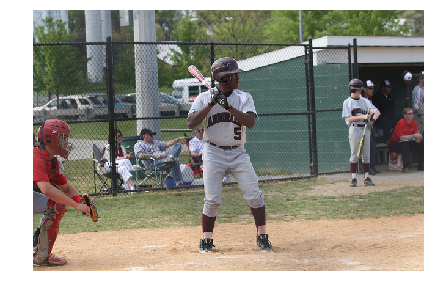

------------------------------------------------------------------


In [ ]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    print ("------------------------------------------------------------------")
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    print ("------------------------------------------------------------------")

show_valid_example(val_img_fns, example_idx=100)

a living room with a couch chair and a tv


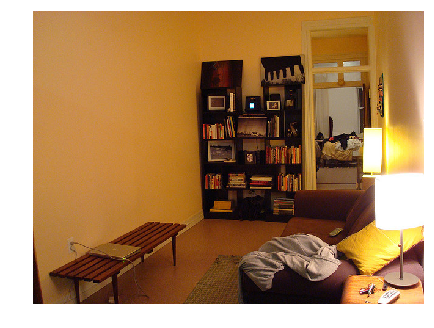

a man sitting at a table with a laptop computer


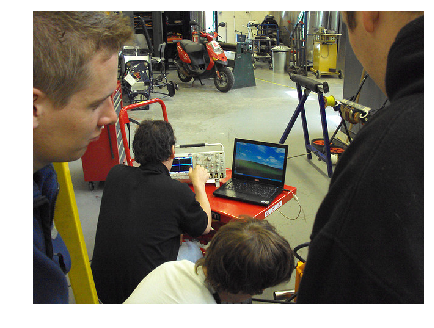

a cell phone is sitting on a table next to a laptop


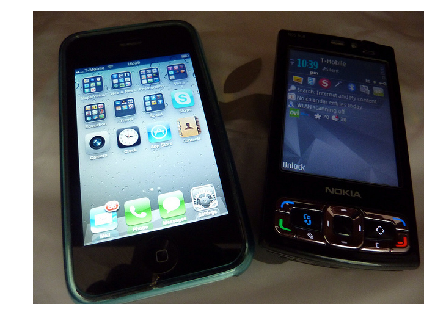

a man is swinging a baseball bat at a baseball game


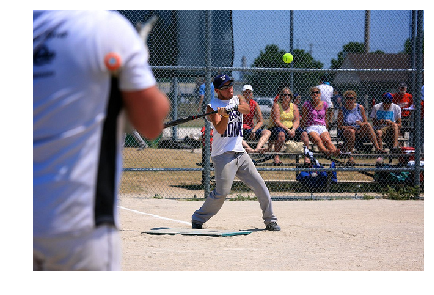

a table with a teddy bear on it


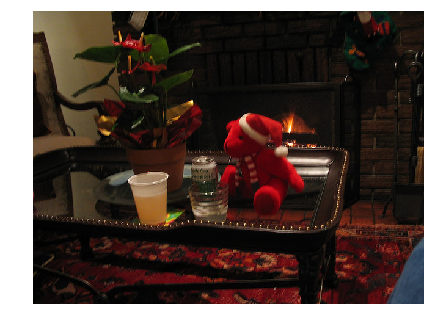

a man is holding a donut in front of a cup of coffee


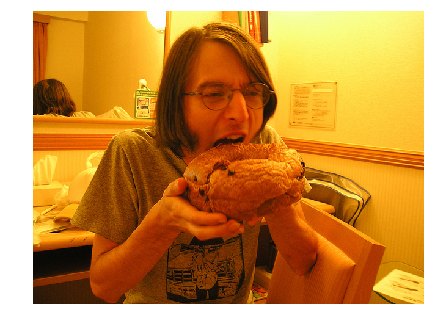

a table with a glass of wine and wine on it


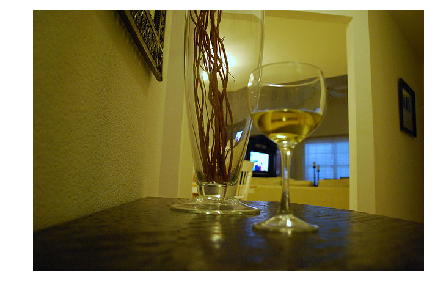

a cat is sitting on a toilet seat


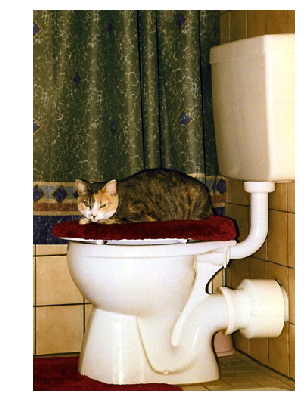

a cat is sitting on a laptop computer


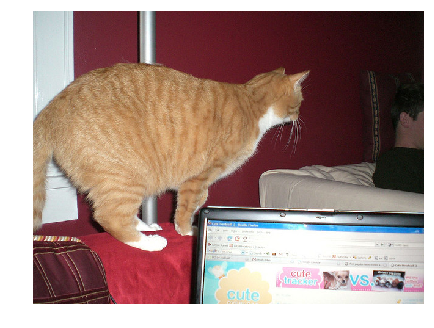

a person is standing on a snowboard in the snow


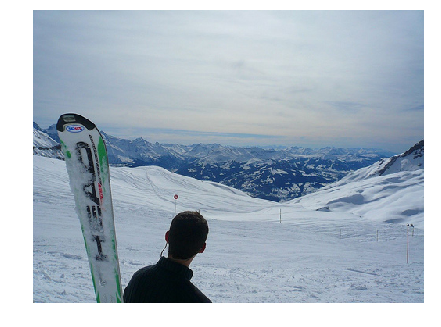

In [ ]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)